# DLHub: A Data and Learning Hub for Science

DLHub is a self-service platform for publishing, applying, and creating machine learning (ML) models, including deep learning (DL) models, and associated data transformations. It is:

1. A **model serving infrastructure**: Users can easily run or test models (and also other related services, such as data transformations) via simple Web calls.

2. A **model registry**: Model developers can easily publish models, along with associated descriptive metadata and training data, so that they can then be discovered, cited, and reused by others.

3. A **model development system**: Developers of new models can easily access the data and computing infrastructure needed to re-train models for new applications.

DLHub benefits users in many ways. Data scientists can publish models (i.e., architectures and weights) and methods. Other scientists can apply existing models to new data with ease (e.g., by querying a prediction API for a deployed model). They can easily create new models with state-of-the-art techniques. Together, these capabilities lower barriers to employing ML/DL, making it easier for researchers to benefit from advances in ML/DL technologies.


## This notebook
This notebook showcases three DLHub use cases: 

1. A **materials property predictor** that extracts data about crystalline materials from the Materials Data Facility before passing it through three servables on DLHub to predict their stability.

2. A **deep learning model for labeling x-ray diffraction images** that generates descriptive tags for x-ray diffraction images.

3. A model used for **discovery of metallic glasses**.

![servables](img/servables.png)

---
# Example 1: A Predictive Model for Formation Enthalpy

Predict the formation enthalpy (a measure of energetic stability) of several crystalline compounds using a machine learning model based on method by [Ward et al.](https://www.nature.com/articles/npjcompumats201628) and data from the OQMD. Here, we show all three steps of running the model - parsing a string to a [pymatgen](http://pymatgen.org/) object, using [matminer](https://hackingmaterials.github.io/matminer/) to compute features, and running a [scikit-learn](http://scikit-learn.org/stable/) model - as independent steps, but you can also execute the entire pipeline as a single call.

![pipeline](img/formation_enthalpy_pipeline.png)


In [10]:
import os
import sys
import json
import requests
import matplotlib
import globus_sdk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

## MDF and DLHub imports
from mdf_forge.forge import Forge
import mdf_toolbox
from dlhub_client import *

In [11]:
mdf = Forge()
dl = DLHub()
creds = mdf_toolbox.login(app_name="DLHub", services=["petrel", "data_mdf", "transfer"])

### Get data from MDF

Gather the composition of a few Al-Cu compounds for which we will predict the formation enthalpy.

In [12]:
results = mdf.search_by_elements(elements=["Al","Cu"], 
                                 source_names=["oqmd"], 
                                 limit=20)
compositions = []
for res in results:
    compositions.append({"composition": res['material']['composition']})
df = pd.DataFrame(compositions)
df.head()

,composition
0,Al2Cu1
1,Al2Cu1
2,Al1Cu1
3,Al1Cu4
4,Al1Cu4


Our dataframe now contains the composition of our materials

### Query DLHub to Find the Model Steps
The `get_servables` command returns a list of all of the servables available in DLHub. Each servable is identified by a human-friendly name and human-unfriendly UUID that is required by the service, but we provide operations so that you don't need to remember it.

In [14]:
df_serv = dl.get_servables()
print('DLHub has {} servables!'.format(len(df_serv)))

DLHub has 9 servables!


Out of these, we can easily find the first step in our pipeline: the parser conversion

In [15]:
df_serv[['uuid', 'name']]

,uuid,name
0,1117ac20-3f54-11e8-b467-0ed5f89f718b,oqmd_model
1,9ff7a98c-3f54-11e8-b467-0ed5f89f718b,matminer_featurize
2,d5a1653c-3ec5-4947-8c5a-28f6554ec339,matminer_util
3,9553d6a2-6a8d-4cda-8b81-7f38efab67e7,formation_energy
4,78d08664-5d52-44a0-b2c8-47cf702b2e39,DLSCORE
5,3a07b0f9-6507-47de-9e42-267ac82a72de,DSIR
6,1e19a78d-547c-483b-9b75-e1ae272a50d6,deep_smiles
7,8c78939e-6422-4627-80ea-03ed8bfdf6ea,metallic_glass
8,e127fb16-5852-11e8-9c2d-fa7ae01bbebc,yager_xrd_classifier


In [ ]:
servable_name = "matminer_util"
servable_id = dl.get_id_by_name(servable_name)
print('Our first step is ID:', servable_id)

### Convert the Compositions to Pymatgen Objects
The first step in running the formation enthalpy model is to take a string, and parse it to a pymatgen Composition object that works with our next step in the toolchain. We seperate this part from the later steps in the pipeline so that other tools could reuse the Composition parser, and we can do some clever pipelining to make the models faster. Normally, you don't need to know this part exists. 

![pipeline](img/formation_enthalpy_1.png)

In [7]:
comps = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    data = {"data":[{"composition":row['composition']}]}
    res = dl.run(servable_id, data)
    comps.append(res['composition_object'][0])
df['composition_object'] = comps
df.head(2)

,composition,composition_object
0,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...
1,Al1Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...


DLHub uses JSON to communicate between processes. As Python objects are not normally JSON-serializable, we first convert it to a `base64` string representation before sending it back to you. You can pretend this does not exist.

### Use Matminer to Compute Features
The key step of building a machine learning models of materials data is to compute informative inputs. For the composition of a material, these are things like the average radius of each of the atoms. We compute 145 of such features using matminer.

![pipeline](img/formation_enthalpy_2.png)

In [8]:
servable_name = "matminer_featurize"
servable_id = dl.get_id_by_name(servable_name)
features = [] 

for i, row in tqdm(df.iterrows(), total=len(df)):
    data = {"data":[{"composition_object":row['composition_object']}]}
    res = dl.run(servable_id, data)
    features.append(res['features'][0])

df['features'] = features
df.head()

,composition,composition_object,features
0,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29..."
1,Al1Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 21.0, 8.0, 13.0, 64.0, 73.0..."
2,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29..."
3,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111..."
4,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111..."


Note that the array now contains a column `features` where each entry is a list of different features that describe a material

## Run the Machine Learning Model
The last step is to invoke a scikit-learn model that takes the features to compute a formation enthalpy.

![pipeline](img/formation_enthalpy_3.png)

In [9]:
servable_name = "oqmd_model"
servable_id = dl.get_id_by_name(servable_name)
preds = []
for i, row in tqdm(df.iterrows(), total=len(df)):
    data = {"data":[{"features":row['features']}]}
    res = dl.run(servable_id, data)
    preds.append(res['prediction'][0])
df['prediction'] = preds
df.head()

,composition,composition_object,features,prediction
0,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29...",-0.183846
1,Al1Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 21.0, 8.0, 13.0, 64.0, 73.0...",-0.179726
2,Al1Cu4,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 25.8, 5.119999999999999, 29...",-0.183846
3,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111...",-0.221089
4,Al2Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 18.333333333333332, 7.11111...",-0.221089


Great! Now we've predicted the stability for all of the materials in our list

## Visualize the result
Just print out our materials with the lowest formation enthalpy, and make a histogram to see the distribution of energies

In [10]:
df.sort_values('prediction', ascending=True).head(3)

,composition,composition_object,features,prediction
5,Al3Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 17.0, 6.0, 13.0, 64.0, 73.0...",-0.234192
18,Al3Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 17.0, 6.0, 13.0, 64.0, 73.0...",-0.234192
10,Al3Cu1,gANjcHltYXRnZW4uY29yZS5jb21wb3NpdGlvbgpDb21wb3...,"[13.0, 29.0, 16.0, 17.0, 6.0, 13.0, 64.0, 73.0...",-0.234192


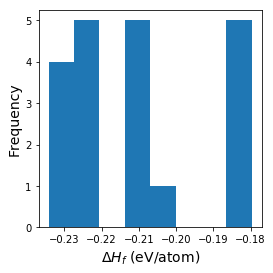

In [11]:
fig, ax = plt.subplots()

ax.hist(df['prediction'], bins=8)

ax.set_xlabel('$\Delta H_f$ (eV/atom)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

fig.set_size_inches(4, 4)

At this point, we've run a prediction of the stability of a few materials without ever having to install any software on our computer.

---
# Example 2: A tagging model for x-ray diffraction images

Here we use a deep learning model developed by [Kevin Yager and colleagues](https://doi.org/10.1109/NYSDS.2017.8085045) at Brookhaven National Laboratory that uses residual deep learning networks to assign useful tags to small angle scattering (SAX) images. Such a model might be used from a light source beamline, for example, to validate data as they are collected.

The servable is set up to retrieve a specified image from Petrel, a multi-petabyte data store at Argonne used to hold data from Advanced Photon Source experiments, and then pass the image through the Yager model.

![resnet](img/resnet_1.png)

## Get a list of data from Petrel

Use the Globus Transfer token to list the contents of a directory on Petrel. 

In [12]:
target_endpoint = "e38ee745-6d04-11e5-ba46-22000b92c6ec"
target_path = "Yager/model/raw/01470b9d_varied_sm/"

ls_result = creds['transfer'].operation_ls(target_endpoint, path=target_path)
bnl_inputs = []
for file_meta in ls_result:
    if file_meta['type'] == "file":
        bnl_inputs.append("https://{}.e.globus.org/{}{}".format(target_endpoint, target_path, file_meta['name']))

## Generate a list of images to pass to the model for labeling
Here is an example image:

![example image](img/0000002f.jpg)

In [13]:
data = []
for filename in bnl_inputs[0:2]:
    print(filename)
    data.append({"file": filename, "token": creds['petrel'].access_token})
df_bnl = pd.DataFrame(data)
df_bnl.head()

https://e38ee745-6d04-11e5-ba46-22000b92c6ec.e.globus.org/Yager/model/raw/01470b9d_varied_sm/00000000.mat
https://e38ee745-6d04-11e5-ba46-22000b92c6ec.e.globus.org/Yager/model/raw/01470b9d_varied_sm/00000001.mat


,file,token
0,https://e38ee745-6d04-11e5-ba46-22000b92c6ec.e...,Agrjpx5EX2andOvgDQj616P2O5yvN23oazB7goQQpjQyDm...
1,https://e38ee745-6d04-11e5-ba46-22000b92c6ec.e...,Agrjpx5EX2andOvgDQj616P2O5yvN23oazB7goQQpjQyDm...


## Invoke the Yager model on one of these images

(This can be a bit slow if the result isn't cached. We are working to optimize.)

In [8]:
servable_name = "yager_xrd_classifier"
servable_id = dl.get_id_by_name(servable_name)

preds=[]

for d in tqdm(data, total=len(data)):
    res = dl.run(servable_id, {"data":[d]})
    preds.append(res[0][0])
df_bnl['prediction'] = preds
df_bnl.head()

NameError: name 'data' is not defined

In [15]:
df_bnl['file'][0]

'https://e38ee745-6d04-11e5-ba46-22000b92c6ec.e.globus.org/Yager/model/raw/01470b9d_varied_sm/00000000.mat'

## Translate predictions into tags
To make these predictions useful to humans...

In [19]:
df_tags = pd.read_csv('./tags.txt',  '\n', header=None) ## Eventually this will be read in from the model metadata in Search

def get_tags(entry):
    df_tmp = pd.DataFrame()
    df_tmp['probability'] = entry['prediction']
    df_tmp['tags'] = df_tags[0]
    return df_tmp

df_p = get_tags(df_bnl.iloc[0])
df_p.sort_values(["probability"], ascending=False).head(10)

,probability,tags
1,0.999999,Beam Off Image
12,0.000764,Ring
15,0.000229,Weak scattering
2,0.000222,Circular Beamstop
8,0.000077,Higher orders
16,0.000004,Wedge beamstop
3,0.000003,Diffuse high-q
6,0.000002,Halo
13,0.000001,Strong scattering
9,0.000001,Linear beamstop


The machine learning model predicts a 99.9% certainity that the beam is off image. We plan to incorporate this kind of model into the beamline facilities at ANL so that scientists (or robots!) at the beamline can quickly identify when their experiments are producing useless data.

---

# Example 3: Metallic Glass Discovery

Model derived from Ren, Ward et al. "Accelerated discovery of metallic glasses through iteration of machine learning and high-throughput experiments" 10.1126/sciadv.aaq1566

![ward](img/ward_1.png)

![ternary](img/ternary_1.png)

In [9]:
servable_name = "metallic_glass"
servable_id = dl.get_id_by_name(servable_name)
elems = ["V","Co","Zr"]

res = dl.run(servable_id, {"data":elems})

KeyboardInterrupt: 

Now let's plot the data to see if we can find interesting areas to investigate

In [ ]:
from utils import ternary_from_data

new_data = {(x, y): pred for pred, x, y in res.get_values()}
ternary_from_data(new_data, elems=elems, scale=25)